In [1]:
import os
import sys
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
%reload_ext autoreload
%autoreload 2

In [11]:
sys.path.append('./')
from helpers.helpers import *
from helpers.mask_to_submission import *

In [125]:
TRAINING_SAMPLES = 100 #max 100

GENERATION_FOLDER = 'data/generated/'
data_dir = 'data/training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 

In [95]:
def read_images(filename, num_images):
    imgs = []
    for i in tqdm(range(1, num_images+1)):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print('File ' + image_filename + ' does not exist')
    print('Loaded {} images'.format(len(imgs)))
    return np.asarray(imgs)

def convert_3c(groundtruths):
    def img_1c_to_3c(gt_img):
        w = gt_img.shape[0]
        h = gt_img.shape[1]
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        return gt_img_3c
    gt_3c = list(map(img_1c_to_3c, groundtruths))
    return np.asarray(gt_3c, dtype='float') / 255 # scale in [0, 1]

images = read_images(train_data_filename, TRAINING_SAMPLES)
groundtruths = read_images(train_labels_filename, TRAINING_SAMPLES) #1 channel groundtruths
masks = convert_3c(groundtruths) # 3 channels groundtruths

  0%|          | 0/100 [00:00<?, ?it/s]

Loaded 100 images


100%|██████████| 100/100 [00:00<00:00, 408.86it/s]


Loaded 100 images


In [122]:
def generate_images(images, masks, data_gen_args, folder, nb_image=TRAINING_SAMPLES, seed=SEED):
    """
    :param data_gen_args: augmentation arguments for the ImageDataGenerator
    :param folder: DO NOT INCLUDE ENDING SLASH "/", name of the folder where the images will be generated 
    :param nb_image: number of images to generate
    :param seed: can be set to None
    """
    #Folder where generate images
    path = GENERATION_FOLDER + folder
    img_path = path + '/images'
    gt_path = path + '/groundtruth'
    if not os.path.isdir(path) or not os.path.isdir(img_path) or not os.path.isdir(gt_path):
        os.mkdir(path)
        os.mkdir(img_path)
        os.mkdir(gt_path)
    
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    # Provide the same seed and keyword arguments to the fit and flow methods
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow(images, batch_size=1, seed=seed) #batchsize of 32
    mask_generator = mask_datagen.flow(masks, batch_size=1, seed=seed)

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    
    #Visualize some augmented data
    fig, axes=plt.subplots(2,2, figsize=(15,10))
    i = 0
    for X_batch, y_batch in train_generator:
        # create a grid of 3x3 images
        img = concatenate_images(X_batch[0], y_batch[0])
        axes[i//2, i%2].imshow(img)
        i += 1
        if i >= 4:
            # show the plot
            plt.show()
            break;
    
    #Generate nb_image new images along with masks
    nb_generated = 1
    for X_batch, y_batch in tqdm(train_generator):
        #Write image and mask
        mpimg.imsave(f"{img_path}/satImage_{nb_generated:03d}.png", X_batch[0])
        mpimg.imsave(f"{gt_path}/satImage_{nb_generated:03d}.png", y_batch[0])

        nb_generated += 1    
        if nb_generated > nb_image:
            break

    print(f"Generated {nb_generated - 1} images in the folder {folder}")

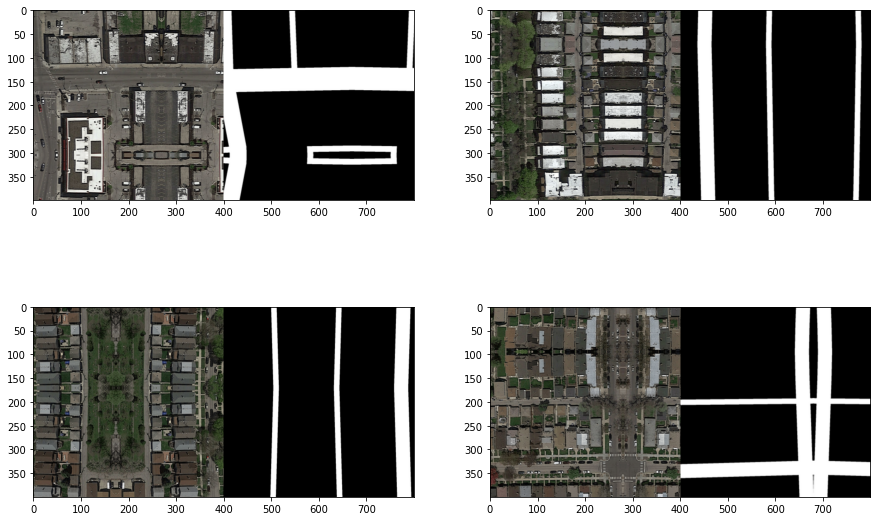

99it [00:28,  3.51it/s]

Generated 100 images in the folder shift


In [124]:
# List of interesting transformations: rotation_range, vertical/horizontal_flip, width/height_shift_range
data_gen_args = dict(fill_mode='reflect',
#                  rotation_range=45,
#                  horizontal_flip=True,
#                  vertical_flip=True,
                 width_shift_range=0.5,
                 height_shift_range=0.5,
                 )

#generate_images(images, masks, data_gen_args, 'shift')